In [1]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

In [2]:
train_data_path = 'cifake dataset/train'
test_data_path = 'cifake dataset/test'

# Create empty lists to store image data and labels
data = []
labels = []

# Loop through the REAL and FAKE subfolders in the train data directory
for folder in os.listdir(train_data_path):
    folder_path = os.path.join(train_data_path, folder)
    label = folder  # Label is either 'REAL' or 'FAKE'

    # Loop through the images in each subfolder
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        image = cv2.imread(image_path)
        image = cv2.resize(image, (32, 32))  # we are given 32*32 images but created check for consistency
        data.append(image)
        labels.append(label)

In [3]:
# Convert data and labels to NumPy arrays
data = np.array(data)
labels = np.array(labels)

# Encode the labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Split the data into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)

In [4]:
# Build the CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))  # Binary classification

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [5]:
# Train the model
model.fit(X_train, y_train, epochs=15, validation_data=(X_val, y_val))

Epoch 1/15
2500/2500 [==============================] - 146s 57ms/step - loss: 0.4508 - accuracy: 0.8290 - val_loss: 0.3434 - val_accuracy: 0.8562
Epoch 2/15
2500/2500 [==============================] - 105s 42ms/step - loss: 0.2886 - accuracy: 0.8792 - val_loss: 0.2710 - val_accuracy: 0.8842
Epoch 3/15
2500/2500 [==============================] - 74s 30ms/step - loss: 0.2500 - accuracy: 0.8981 - val_loss: 0.2396 - val_accuracy: 0.9021
Epoch 4/15
2500/2500 [==============================] - 70s 28ms/step - loss: 0.2317 - accuracy: 0.9064 - val_loss: 0.2372 - val_accuracy: 0.9066
Epoch 5/15
2500/2500 [==============================] - 75s 30ms/step - loss: 0.2157 - accuracy: 0.9142 - val_loss: 0.3158 - val_accuracy: 0.8759
Epoch 6/15
2500/2500 [==============================] - 73s 29ms/step - loss: 0.1976 - accuracy: 0.9222 - val_loss: 0.2123 - val_accuracy: 0.9142
Epoch 7/15
2500/2500 [==============================] - 77s 31ms/step - loss: 0.1843 - accuracy: 0.9280 - val_loss: 0.2523

In [24]:
# Make predictions on the validation data
val_predictions = model.predict(X_val)

  1/625 [..............................] - ETA: 17s

625/625 [==============================] - 5s 8ms/step


In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Convert probabilities to binary predictions using a threshold (0.5 in this case)
binary_val_predictions = (val_predictions > 0.5).astype(int)

# Calculate precision, recall, and F1-Score on the validation data
precision = precision_score(y_val, binary_val_predictions)
recall = recall_score(y_val, binary_val_predictions)
f1 = f1_score(y_val, binary_val_predictions)
print("Validation Precision:", precision)
print("Validation Recall:", recall)
print("Validation F1-Score:", f1)


# Calculate the confusion matrix on the validation data
conf_matrix = confusion_matrix(y_val, binary_val_predictions)
print("Validation Confusion Matrix:")
print(conf_matrix)

# Calculate specificity and false positive rate on the validation data
tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp)
fpr = fp / (tn + fp)
print("Validation Specificity:", specificity)
print("Validation False Positive Rate:", fpr)

Validation Precision: 0.8858751759737212
Validation Recall: 0.947215253386854
Validation F1-Score: 0.9155189136760427
Validation Confusion Matrix:
[[8819 1216]
 [ 526 9439]]
Validation Specificity: 0.8788241155954161
Validation False Positive Rate: 0.12117588440458396


625/625 [==============================] - 5s 8ms/step
Validation ROC Curve and AUC-ROC:


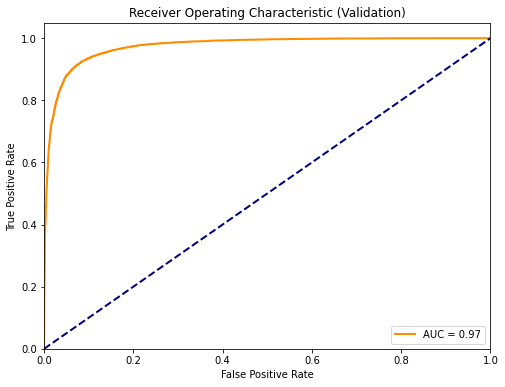

Validation Precision-Recall Curve and AUC-PR:


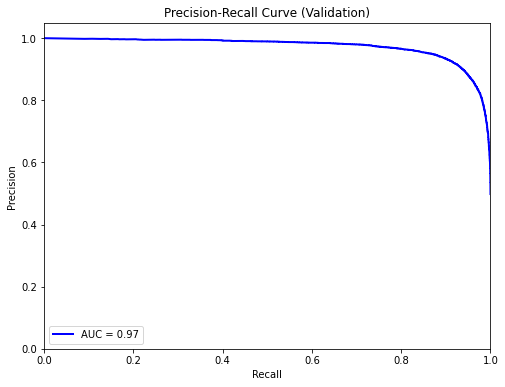

In [26]:
# Calculate ROC curve and AUC-ROC on the validation data
y_prob = model.predict(X_val)
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)
print("Validation ROC Curve and AUC-ROC:")
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Validation)')
plt.legend(loc='lower right')
plt.show()

# Calculate Precision-Recall curve and AUC-PR on the validation data
precision, recall, _ = precision_recall_curve(y_val, y_prob)
pr_auc = average_precision_score(y_val, y_prob)
print("Validation Precision-Recall Curve and AUC-PR:")
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'AUC = {pr_auc:.2f}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Validation)')
plt.legend(loc='lower left')
plt.show()


### TEST DATA

In [27]:
# Load and preprocess the test data
test_data = []
test_labels = []

for folder in os.listdir(test_data_path):
    folder_path = os.path.join(test_data_path, folder)
    label = folder  # Label is either 'REAL' or 'FAKE'

    # Loop through the images in each subfolder
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        image = cv2.imread(image_path)
        image = cv2.resize(image, (32, 32))  # we are given 32*32 images but created check for consistency
        test_data.append(image)
        test_labels.append(label)

In [36]:
# Convert test data to a NumPy array
test_data = np.array(test_data)
# test_data = np.array([cv2.resize(image, (32, 32)) for image in test_data])

# Make predictions on the test data
test_predictions = model.predict(test_data)

# Convert probabilities to binary predictions using a threshold (0.5 in this case)
binary_test_predictions = (test_predictions > 0.5).astype(int)

# Map the predicted labels back to 'real' and 'fake'
test_predictions_labels = label_encoder.inverse_transform(binary_test_predictions)

# Calculate accuracy on the test data
test_accuracy = accuracy_score(test_labels, test_predictions_labels)
print("Test Accuracy:", test_accuracy)


625/625 [==============================] - 5s 8ms/step
Test Accuracy: 0.9147


c:\Users\paris\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [37]:
from sklearn.preprocessing import LabelBinarizer

# Convert labels to binary format
label_binarizer = LabelBinarizer()
binary_test_labels = label_binarizer.fit_transform(test_labels)

In [41]:
# Convert probabilities to binary predictions using a threshold (0.5 in this case)
binary_test_predictions = (test_predictions > 0.5).astype(int)

# Calculate precision, recall, and F1-Score on the test data
test_precision = precision_score(binary_test_labels, binary_test_predictions, pos_label=1)
test_recall = recall_score(binary_test_labels, binary_test_predictions, pos_label=1)
test_f1 = f1_score(binary_test_labels, binary_test_predictions, pos_label=1)

print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1-Score:", test_f1)

# Calculate the confusion matrix on the test data
test_conf_matrix = confusion_matrix(binary_test_labels, binary_test_predictions)
print("Test Confusion Matrix:")
print(test_conf_matrix)

# Calculate specificity and false positive rate on the test data
tn, fp, fn, tp = test_conf_matrix.ravel()
test_specificity = tn / (tn + fp)
test_fpr = fp / (tn + fp)
print("Test Specificity:", test_specificity)
print("Test False Positive Rate:", test_fpr)

Test Precision: 0.8863424632010434
Test Recall: 0.9514
Test F1-Score: 0.9177196874698563
Test Confusion Matrix:
[[8780 1220]
 [ 486 9514]]
Test Specificity: 0.878
Test False Positive Rate: 0.122


Test ROC Curve and AUC-ROC:


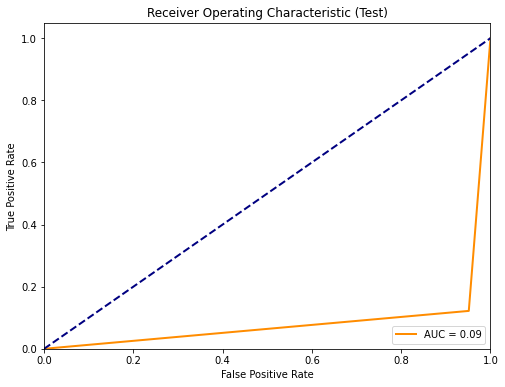

Test Precision-Recall Curve and AUC-PR:


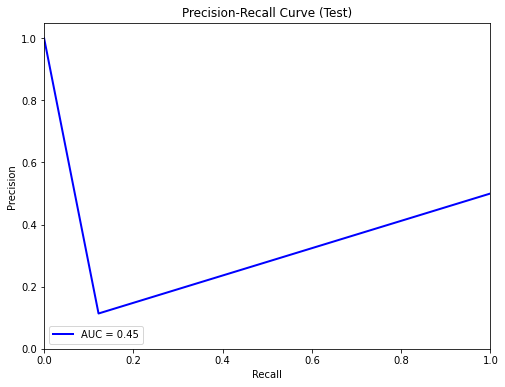

In [42]:
# Calculate ROC curve and AUC-ROC on the test data
test_fpr, test_tpr, _ = roc_curve(test_labels, binary_test_predictions, pos_label='FAKE')
test_roc_auc = auc(test_fpr, test_tpr)
print("Test ROC Curve and AUC-ROC:")
plt.figure(figsize=(8, 6))
plt.plot(test_fpr, test_tpr, color='darkorange', lw=2, label=f'AUC = {test_roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Test)')
plt.legend(loc='lower right')
plt.show()

# Calculate Precision-Recall curve and AUC-PR on the test data
test_precision, test_recall, _ = precision_recall_curve(test_labels, binary_test_predictions, pos_label='FAKE')
test_pr_auc = average_precision_score(test_labels, binary_test_predictions, pos_label='FAKE')
print("Test Precision-Recall Curve and AUC-PR:")
plt.figure(figsize=(8, 6))
plt.plot(test_recall, test_precision, color='blue', lw=2, label=f'AUC = {test_pr_auc:.2f}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Test)')
plt.legend(loc='lower left')
plt.show()
